In [2]:
import calendar
import numpy as np
import pandas as pd
# from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Data	
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [3]:
bike_rental_data = pd.read_csv("hour.csv")
print(bike_rental_data.shape)
bike_rental_data.head(1)

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16


(array([ 6972.,  3705.,  2659.,  1660.,   987.,   663.,   369.,   188.,
          139.,    37.]),
 array([   1. ,   98.6,  196.2,  293.8,  391.4,  489. ,  586.6,  684.2,
         781.8,  879.4,  977. ]),
 <a list of 10 Patch objects>)

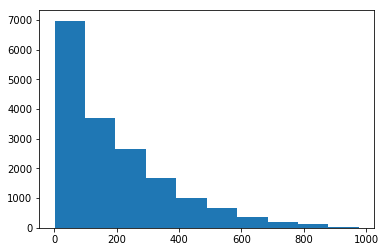

In [3]:
# histogram of target column
plt.hist(bike_rental_data['cnt'])

#### Correlation between each column with target column 'cnt'

In [4]:
bike_rental_data.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

#### Scaling target variables

In [4]:
def scale_var (data):
#     quant_features = ['temp', 'hum', 'windspeed', 'cnt']
    quant_features = ['cnt']
    # Store scalings in a dictionary so we can convert back later
    scaled_features = {}
    for each in quant_features:
        mean, std = data[each].mean(), data[each].std()
        scaled_features[each] = [mean, std]
        data.loc[:, each] = (data[each] - mean)/std
    return data

#### Binary variable
Get binary variables for "season", "weathersit", "mnth", 'hr', and 'weekday'.

In [5]:
def binary_var (data, scale=False):
    processed_data = data
    dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
    for each in dummy_fields:
        dummies = pd.get_dummies(processed_data[each], prefix=each, drop_first=False)
        processed_data = pd.concat([processed_data, dummies], axis=1)
    
    fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                      'weekday', 'atemp', 'mnth', 'workingday', 'hr']
    processed_data = processed_data.drop(fields_to_drop, axis=1)
    if (scale):
        processed_data = scale_var (processed_data)
    return processed_data

#### Splitting the data into training, testing, and validation sets

In [6]:
# get processed data
processed_data = binary_var(bike_rental_data)

# save the last 21 days for testing data
# and the last of 60 days of the remaining data as a validatoin set
train_data = processed_data[:-30*24]
test_data = processed_data[-30*24:]

target_fields = ['cnt', 'casual', 'registered']
x_train, y_train = train_data.drop(target_fields, axis=1), train_data['cnt'] #[:-60*24]
x_test, y_test = test_data.drop(target_fields, axis=1), test_data['cnt']

print("x_train: {}, y_train: {}".format(x_train.shape, y_train.shape))
print("x_test: {}, y_test: {}".format(x_test.shape, y_test.shape))

x_train: (16659, 56), y_train: (16659,)
x_test: (720, 56), y_test: (720,)


#### RMSLE Scorer

In [8]:
def rmsle(y, y_, convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

#### Linear Regression Model

In [10]:
# Initialize logistic regression model
lr = LinearRegression()

# Train the model
y_train_log = np.log1p(y_train)
lr.fit(X=x_train, y=y_train_log)

# Make predictions
train_preds = lr.predict(X=x_train)
train_err_lr = rmsle(y_train_log, train_preds, True)
y_test_log = np.log1p(y_test)
test_preds = lr.predict(X=x_test)
test_err_lr = rmsle(y_test_log, test_preds, True)

print("RMSLE value for training set: ", train_err_lr)
print("RMSLE value for testing set: ", test_err_lr)

plt.subplot(211)
plt.plot(np.exp(y_train_log).values[1:200], label='y_train')
plt.plot(np.exp(train_preds)[1:200], label='y_pred')
plt.title('Labels v.s. Preds')
plt.ylabel('count')
plt.legend()
plt.subplot(212)
plt.plot(np.exp(y_test_log).values[1:200], label='y_test')
plt.plot(np.exp(test_preds)[1:200], label='y_pred')
plt.legend()
plt.ylabel('count')
plt.xlabel('day')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### Linear Regression Model w/ Cross Validation

In [11]:
n_folds = 10
x_train_folds = np.array_split(x_train, n_folds)
y_train_folds = np.array_split(y_train.reshape(-1,1), n_folds)
train_err_cv = []
val_err_cv = []

for i in range(n_folds):
    x_train_fold = np.vstack(x_train_folds[:i] + x_train_folds[i+1:])
    y_train_fold = np.vstack(y_train_folds[:i] + y_train_folds[i+1:])[:,0]

    y_train_log = np.log1p(y_train_fold)
    lr.fit(X=x_train_fold, y=y_train_log)
    train_preds = lr.predict(X=x_train_fold)
    train_err_cv.append(rmsle(y_train_log, train_preds, True)) 
    
    # validation
    y_val_log = np.log1p(y_train_folds[i])
    val_preds = lr.predict(X=x_train_folds[i])
    val_err_cv.append(rmsle(y_val_log, val_preds, True))
    
# test    
y_test_log = np.log1p(y_test)
test_preds = lr.predict(X=x_test)
test_err_lr = rmsle(y_test_log, test_preds, True)

print("With {}-fold Cross Validation, RMSLE value for training set: {}".format(n_folds,np.mean(train_err_cv)))
print("With {}-fold Cross Validation, RMSLE value for val set: {}".format(n_folds,np.mean(val_err_cv)))
print("With {}-fold Cross Validation, RMSLE value for testing set: {}".format(n_folds,test_err_lr))

With 10-fold Cross Validation, RMSLE value for training set: 0.5621238281473141
With 10-fold Cross Validation, RMSLE value for val set: 1.7693476364843317
With 10-fold Cross Validation, RMSLE value for testing set: 0.6727999937357636


#### Ridge Regression Model

parameters:  {'alpha': 10.0, 'max_iter': 3000}
RMSLE value for training set:  0.561143208208
RMSLE value for testing set:  0.657445718673


Text(0.5,0,'day')

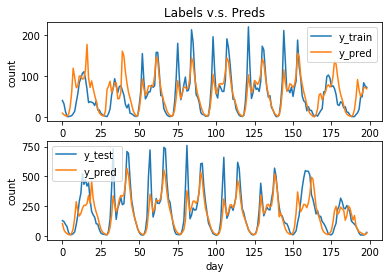

In [12]:
ridge = Ridge()
alpha = np.array([0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50])
ridge_params_ = {'max_iter':[3000], 'alpha': alpha}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge, ridge_params_, scoring=rmsle_scorer, cv=10)

# Train the model
y_train_log = np.log1p(y_train)
grid_ridge_m.fit(X=x_train, y=y_train_log)

# Make predictions
train_preds = grid_ridge_m.predict(X=x_train)
train_err_ridge = rmsle(y_train_log, train_preds, True)
y_test_log = np.log1p(y_test)
test_preds = grid_ridge_m.predict(X=x_test)
test_err_ridge = rmsle(y_test_log, test_preds, True)

print("parameters: ", grid_ridge_m.best_params_)
print("RMSLE value for training set: ", train_err_ridge)
print("RMSLE value for testing set: ", test_err_ridge)

plt.subplot(211)
plt.plot(np.exp(y_train_log).values[1:200], label='y_train')
plt.plot(np.exp(train_preds)[1:200], label='y_pred')
plt.title('Labels v.s. Preds')
plt.ylabel('count')
plt.legend()
plt.subplot(212)
plt.plot(np.exp(y_test_log).values[1:200], label='y_test')
plt.plot(np.exp(test_preds)[1:200], label='y_pred')
plt.legend()
plt.ylabel('count')
plt.xlabel('day')

#### Ridge Regression Model w/ Cross Validation

In [13]:
alpha = np.array([0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000,2000,5000])
n_folds = 10
x_train_folds = np.array_split(x_train, n_folds)
y_train_folds = np.array_split(y_train.reshape(-1,1), n_folds)
train_errs = []
val_errs = []
test_errs = []
print("With {}-fold Cross Validation:".format(n_folds))
print('alpha\ttrain\tval\ttest')
for a in alpha:
    ridge = Ridge(fit_intercept=True, alpha=a)
    train_err_cv = []
    val_err_cv = []
    for i in range(n_folds):
        x_train_fold = np.vstack(x_train_folds[:i] + x_train_folds[i+1:])
        y_train_fold = np.vstack(y_train_folds[:i] + y_train_folds[i+1:])[:,0]
        
        y_train_log = np.log1p(y_train_fold)
        ridge.fit(X=x_train_fold, y=y_train_log)
        train_preds = ridge.predict(X=x_train_fold)
        train_err_cv.append(rmsle(y_train_log, train_preds, True)) 

        # validation
        y_val_log = np.log1p(y_train_folds[i])
        val_preds = ridge.predict(X=x_train_folds[i])
        val_err_cv.append(rmsle(y_val_log, val_preds, True))
    
    # test
    y_test_log = np.log1p(y_test)
    test_preds = ridge.predict(X=x_test)
    test_err_ridge = rmsle(y_test_log, test_preds, True)
    
    train_errs.append(np.mean(train_err_cv))
    val_errs.append(np.mean(val_err_cv))
    test_errs.append(test_err_ridge)
    print('{:.2f}\t{:.4f}\t{:.4f}\t{:.4f}'.format(a, np.mean(train_err_cv), np.mean(val_err_cv), test_err_ridge))

With 10-fold Cross Validation:
alpha	train	val	test
0.01	0.5601	1.7674	0.6594
0.02	0.5601	1.7674	0.6594
0.05	0.5601	1.7674	0.6594
0.10	0.5601	1.7673	0.6594
0.20	0.5601	1.7672	0.6594
0.50	0.5600	1.7669	0.6594
1.00	0.5600	1.7663	0.6594
2.00	0.5600	1.7651	0.6594
5.00	0.5601	1.7618	0.6593
10.00	0.5602	1.7562	0.6594
20.00	0.5610	1.7456	0.6597
50.00	0.5659	1.7162	0.6631
100.00	0.5805	1.6742	0.6741
200.00	0.6201	1.6090	0.7066
500.00	0.7421	1.4948	0.8129
1000.00	0.8830	1.4148	0.9403
2000.00	1.0293	1.3661	1.0749
5000.00	1.1810	1.3496	1.2148


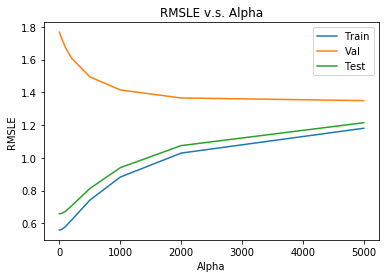

In [14]:
plt.plot(alpha, train_errs, label='Train')
plt.plot(alpha, val_errs, label='Val')
plt.plot(alpha, test_errs, label='Test')
plt.legend(('Train', 'Val', 'Test'))
plt.title('RMSLE v.s. Alpha')
plt.ylabel('RMSLE')
plt.xlabel('Alpha')
plt.show()

#### Lasso Regression Model

parameters:  {'alpha': 0.001, 'max_iter': 3000}
RMSLE value for training set:  0.561676030379
RMSLE value for testing set:  0.654766979323


Text(0.5,0,'day')

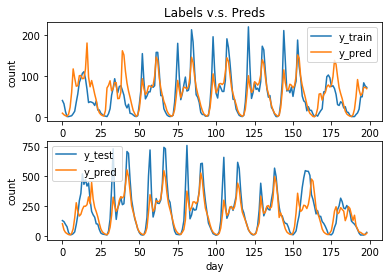

In [15]:
lasso = Lasso()
alphas = np.array([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 1])
lasso_params_ = {'max_iter':[3000], 'alpha':alphas}
grid_lasso_m = GridSearchCV(lasso, lasso_params_, scoring=rmsle_scorer, cv=10)

# Train the model
y_train_log = np.log1p(y_train)
grid_lasso_m.fit(X=x_train, y=y_train_log)

# Make predictions
train_preds = grid_lasso_m.predict(X=x_train)
train_err_lasso = rmsle(y_train_log, train_preds, True)
y_test_log = np.log1p(y_test)
test_preds = grid_lasso_m.predict(X=x_test)
test_err_lasso = rmsle(y_test_log, test_preds, True)

print("parameters: ", grid_lasso_m.best_params_)
print("RMSLE value for training set: ", train_err_lasso)
print("RMSLE value for testing set: ", test_err_lasso)

plt.subplot(211)
plt.plot(np.exp(y_train_log).values[1:200], label='y_train')
plt.plot(np.exp(train_preds)[1:200], label='y_pred')
plt.title('Labels v.s. Preds')
plt.ylabel('count')
plt.legend()
plt.subplot(212)
plt.plot(np.exp(y_test_log).values[1:200], label='y_test')
plt.plot(np.exp(test_preds)[1:200], label='y_pred')
plt.legend()
plt.ylabel('count')
plt.xlabel('day')

#### Lasso Regression Model w/ Cross Validation

In [17]:
alpha  = 1/np.array([500000,200000,100000,50000,20000,10000,5000,2000,1000,500,200,100,50,20,10,5,2,1,0.5,0.2,0.1])
n_folds = 10
x_train_folds = np.array_split(x_train, n_folds)
y_train_folds = np.array_split(y_train.reshape(-1,1), n_folds)
train_errs = []
val_errs = []
test_errs = []
print("With {}-fold Cross Validation:".format(n_folds))
print('alpha\t\ttrain\tval\ttest')
for a in alpha:
    lasso = Lasso(fit_intercept=True, alpha=a)
    train_err_cv = []
    val_err_cv = []
    for i in range(n_folds):
        x_train_fold = np.vstack(x_train_folds[:i] + x_train_folds[i+1:])
        y_train_fold = np.vstack(y_train_folds[:i] + y_train_folds[i+1:])[:,0]
        
        y_train_log = np.log1p(y_train_fold)
        lasso.fit(X=x_train_fold, y=y_train_log)
        train_preds = lasso.predict(X=x_train_fold)
        train_err_cv.append(rmsle(y_train_log, train_preds, True)) 

        # validation
        y_val_log = np.log1p(y_train_folds[i])
        val_preds = lasso.predict(X=x_train_folds[i])
        val_err_cv.append(rmsle(y_val_log, val_preds, True))
          
    # test    
    y_test_log = np.log1p(y_test)
    test_preds = lasso.predict(X=x_test)
    test_err_lasso = rmsle(y_test_log, test_preds, True)
    
    train_errs.append(np.mean(train_err_cv))
    val_errs.append(np.mean(val_err_cv))
    test_errs.append(test_err_lasso)
    print('{:.6f}\t{:.4f}\t{:.4f}\t{:.4f}'.format(a, np.mean(train_err_cv), np.mean(val_err_cv), test_err_lasso))

With 10-fold Cross Validation:
alpha		train	val	test
0.000002	0.5601	1.7674	0.6594
0.000005	0.5601	1.7674	0.6594
0.000010	0.5601	1.7673	0.6595
0.000020	0.5601	1.7672	0.6595
0.000050	0.5601	1.7667	0.6596
0.000100	0.5601	1.7661	0.6602
0.000200	0.5601	1.7648	0.6606
0.000500	0.5602	1.7610	0.6599
0.001000	0.5608	1.7548	0.6592
0.002000	0.5629	1.7432	0.6594
0.005000	0.5736	1.7105	0.6702
0.010000	0.6024	1.6618	0.6969
0.020000	0.6839	1.5796	0.7795
0.050000	0.9649	1.4263	1.0353
0.100000	1.3208	1.3755	1.3321
0.200000	1.3663	1.3791	1.3751
0.500000	1.3663	1.3791	1.3751
1.000000	1.3663	1.3791	1.3751
2.000000	1.3663	1.3791	1.3751
5.000000	1.3663	1.3791	1.3751
10.000000	1.3663	1.3791	1.3751


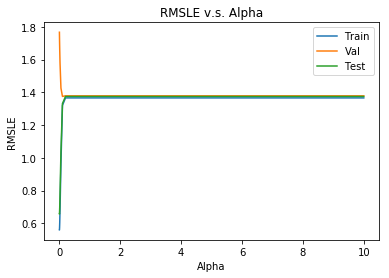

In [17]:
plt.plot(alpha, train_errs, label='Train')
plt.plot(alpha, val_errs, label='Val')
plt.plot(alpha, test_errs, label='Test')
plt.legend(('Train', 'Val', 'Test'))
plt.title('RMSLE v.s. Alpha')
plt.ylabel('RMSLE')
plt.xlabel('Alpha')
plt.show()

#### Random Forest

RMSLE value for training set:  0.125363283603
RMSLE value for testing set:  0.53279460177


Text(0.5,0,'day')

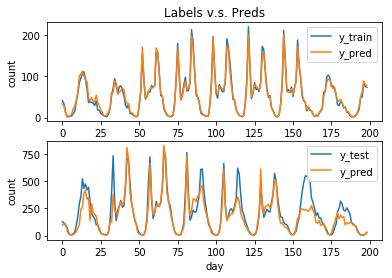

In [13]:
rfModel = RandomForestRegressor(n_estimators=30)

# Train the model
y_train_log = np.log1p(y_train)
rfModel.fit(X=x_train, y=y_train_log)

# Make predictions
train_preds = rfModel.predict(X=x_train)
train_err_rf = rmsle(y_train_log, train_preds, True)
y_test_log = np.log1p(y_test)
test_preds = rfModel.predict(X=x_test)
test_err_rf = rmsle(y_test_log, test_preds, True)

print("RMSLE value for training set: ", train_err_rf)
print("RMSLE value for testing set: ", test_err_rf)

plt.subplot(211)
plt.plot(np.exp(y_train_log).values[1:200], label='y_train')
plt.plot(np.exp(train_preds)[1:200], label='y_pred')
plt.title('Labels v.s. Preds')
plt.ylabel('count')
plt.legend()
plt.subplot(212)
plt.plot(np.exp(y_test_log).values[1:200], label='y_test')
plt.plot(np.exp(test_preds)[1:200], label='y_pred')
plt.legend()
plt.ylabel('count')
plt.xlabel('day')